# Продажи австралийского вина

Известны ежемесячные продажи австралийского вина в тысячах литров с января 1980 по июль 1995, необходимо построить прогноз на следующие три года.

In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


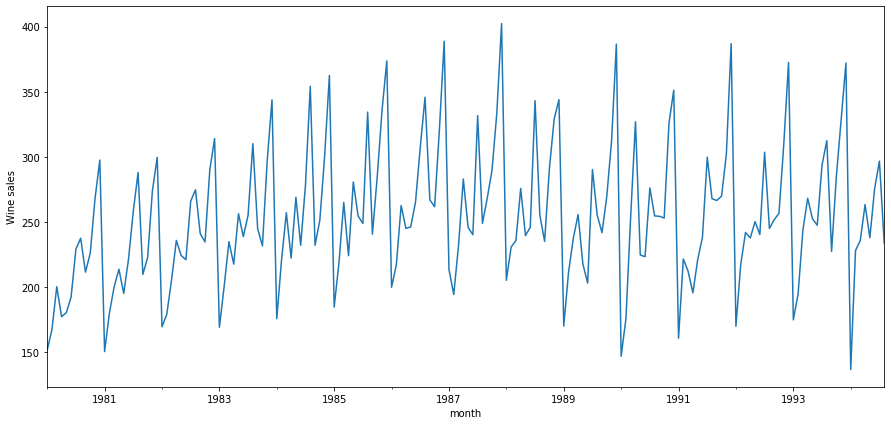

In [2]:
wine = pd.read_csv('./data/monthly-australian-wine-sales.csv',',', index_col=['month'], parse_dates=['month'], dayfirst=True)
wine['sales'] = wine['sales']/100000
wine.sales = wine.sales * 1000
plt.figure(figsize(15,7))
wine.sales.plot()
plt.ylabel('Wine sales')
pylab.show()

Проверка стационарности и STL-декомпозиция ряда:
набор эвристик из которых состоит наш ряд

Критерий Дики-Фуллера: p=0.051161


<Figure size 1080x720 with 0 Axes>

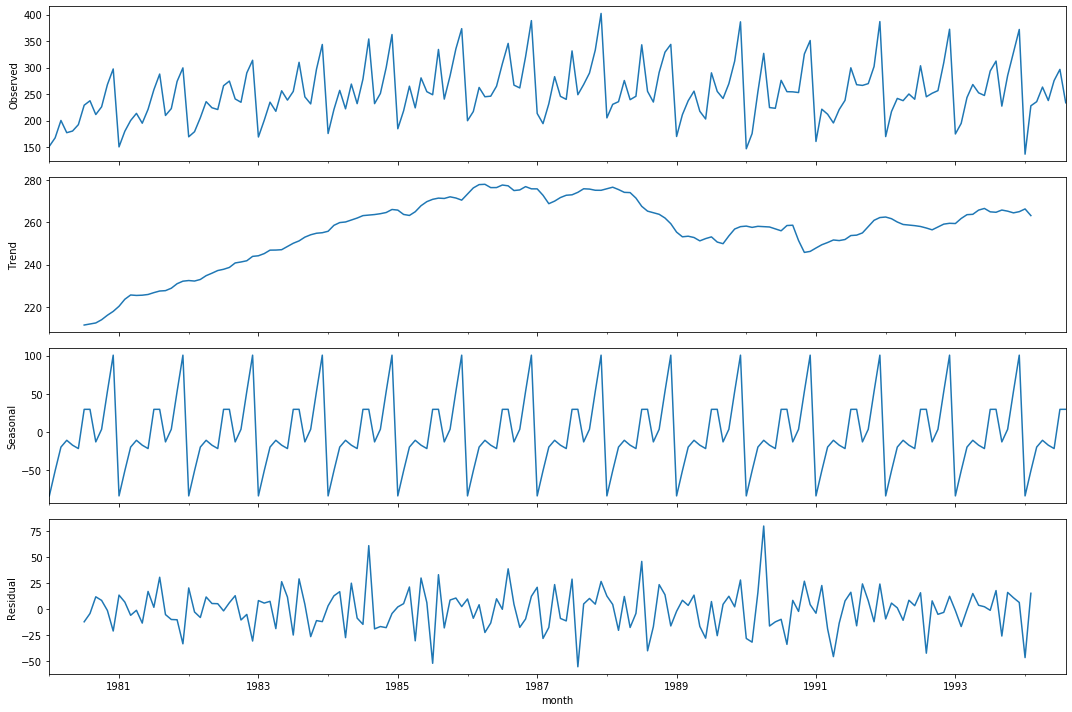

In [3]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wine.sales).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wine.sales)[1])

### Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.236675
Критерий Дики-Фуллера: p=0.029565


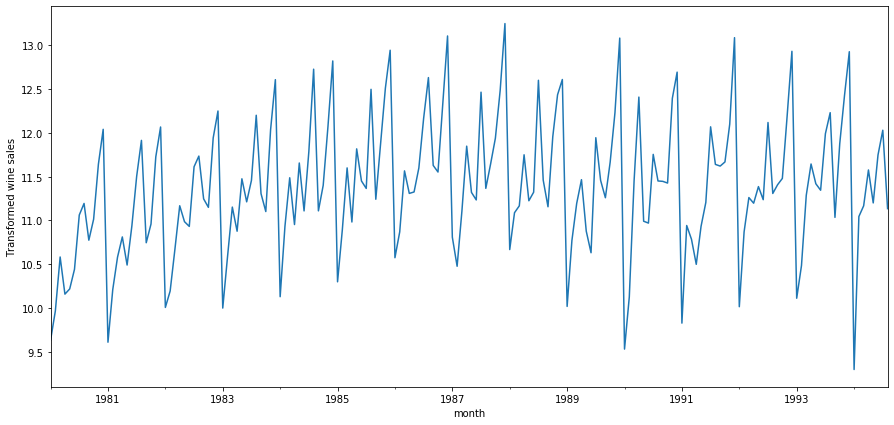

In [4]:
wine['sales_box'], lmbda = stats.boxcox(wine.sales)
plt.figure(figsize(15,7))
wine.sales_box.plot()
plt.ylabel(u'Transformed wine sales')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wine.sales_box)[1])

### Стационарность

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но визуально в данных виден тренд. Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.128317


<Figure size 1080x720 with 0 Axes>

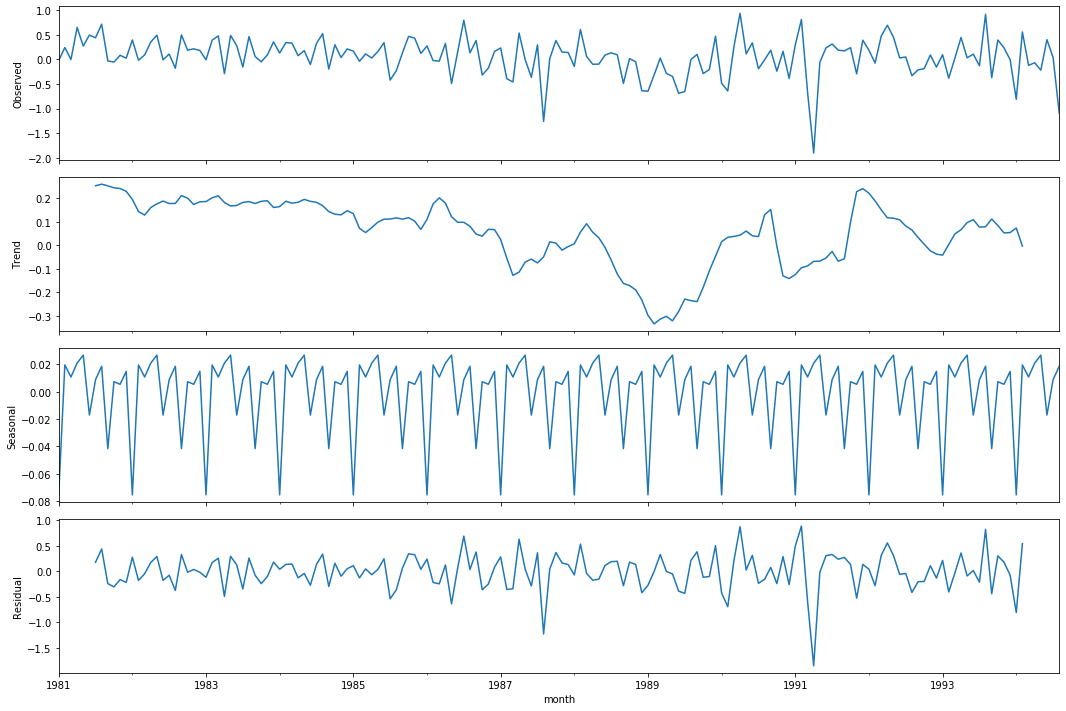

In [5]:
wine['sales_box_diff'] = wine.sales_box - wine.sales_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wine.sales_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wine.sales_box_diff[12:])[1])

Критерий Дики-Фуллера не отвергает гипотезу нестационарности, и полностью избавиться от тренда не удалось. Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000002


<Figure size 1080x720 with 0 Axes>

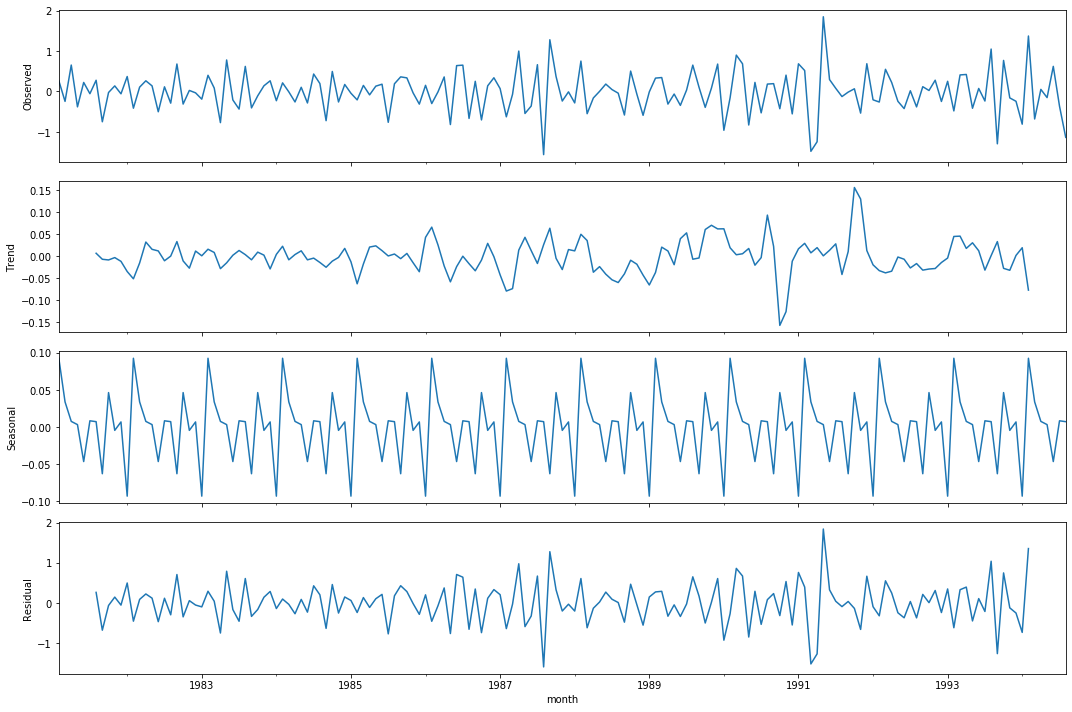

In [6]:
wine['sales_box_diff2'] = wine.sales_box_diff - wine.sales_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wine.sales_box_diff2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wine.sales_box_diff2[13:])[1])

Гипотеза нестационарности отвергается, и визуально ряд выглядит лучше — тренда больше нет. 

## Подбор модели

Посмотрим на ACF и PACF полученного ряда:

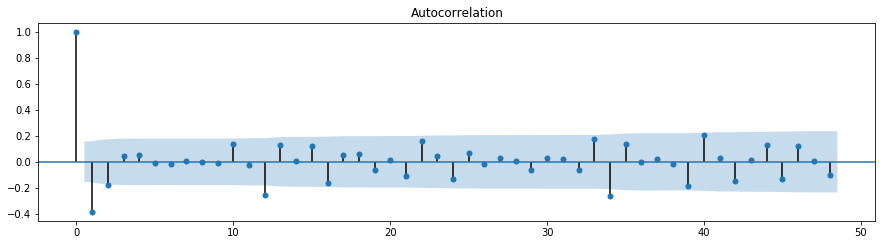

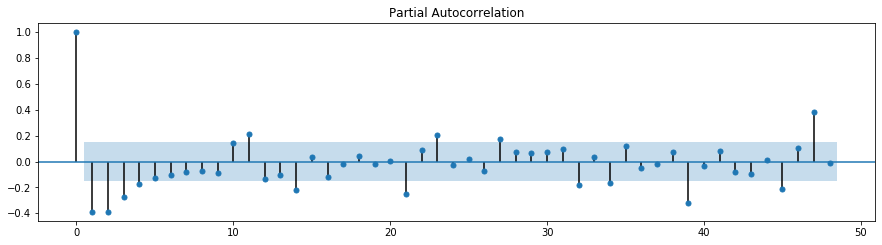

In [7]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(wine.sales_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(wine.sales_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
#максимально сезонный лаг 12
#максимально несезоный лаг 4

Начальные приближения: Q=1, q=2, P=1, p=4

In [8]:
ps = range(0, 5)
d=1
qs = range(0, 3)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

In [9]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

60

In [10]:
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        
        model=sm.tsa.statespace.SARIMAX(wine.sales_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
        
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

In [11]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters         aic
29  (2, 1, 0, 1)  119.511282
31  (2, 1, 1, 1)  120.495823
45  (3, 2, 0, 1)  120.877470
33  (2, 2, 0, 1)  120.993594
41  (3, 1, 0, 1)  121.433179


Лучшая модель:

In [12]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                          sales_box   No. Observations:                  176
Model:             SARIMAX(2, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 -54.756
Date:                            Thu, 01 Aug 2019   AIC                            119.511
Time:                                    18:42:45   BIC                            134.980
Sample:                                01-01-1980   HQIC                           125.791
                                     - 08-01-1994                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1506      0.085     -1.763      0.078      -0.318       0.017
ar.L2         -0.1990      0.111     -1.799      0.072      -0.416       0.018
ma.L1         -0.8394      0.055    -15.259      0.000      -0.947      -0.732
ma.S.L12      -0.6689      0.052    -12.747      0.000      -0.772      -0.566
sigma2         0.1084      0.009     11.769      0.000       0.090       0.126
===================================================================================
Ljung-Box (Q):                       40.31   Jarque-Bera (JB):                25.57
Prob(Q):                              0.46   Prob(JB):                         0.00
Heteroskedasticity (H):               2.37   Skew:                            -0.48
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Её остатки:

Критерий Стьюдента: p=0.258218
Критерий Дики-Фуллера: p=0.000000


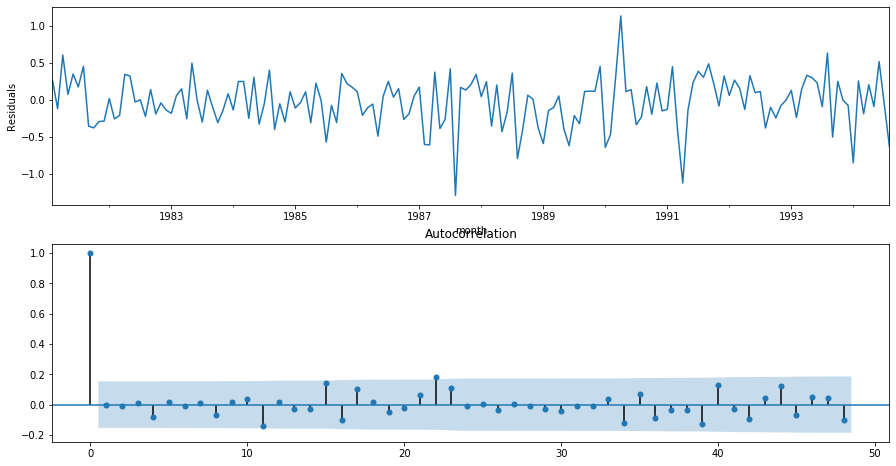

In [13]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).
Посмотрим, насколько хорошо модель описывает данные:

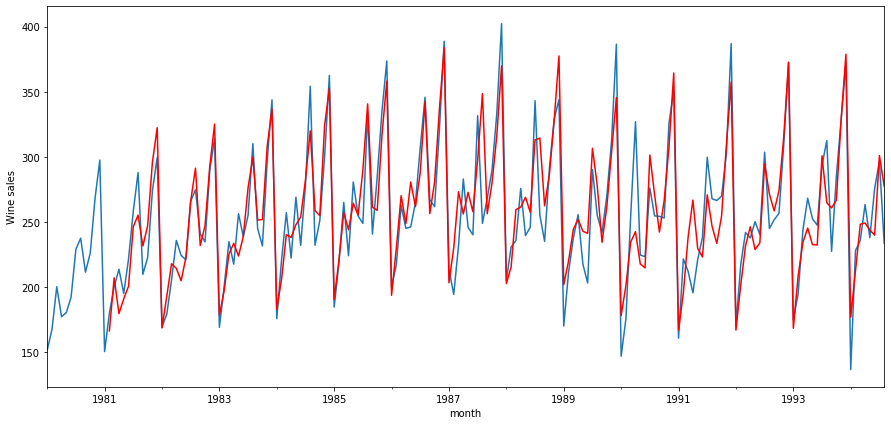

In [14]:
wine['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
wine.sales.plot()
wine.model[13:].plot(color='r')
plt.ylabel('Wine sales')
pylab.show()

### Прогноз

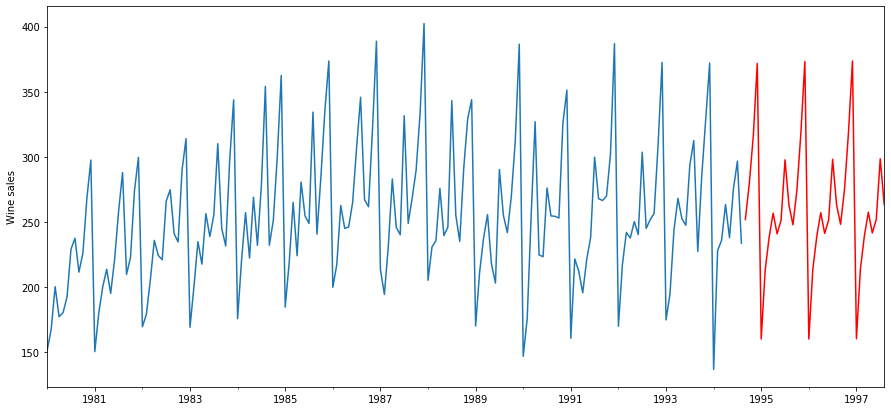

In [15]:
wine2 = wine[['sales']]
date_list = [datetime.datetime.strptime("1994-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= wine2.columns)
wine2 = pd.concat([wine2, future])
wine2['forecast'] = invboxcox(best_model.predict(start=176, end=211), lmbda)

plt.figure(figsize(15,7))
wine2.sales.plot()
wine2.forecast.plot(color='r')
plt.ylabel('Wine sales')
pylab.show()

In [16]:
int(wine2[(wine2.index >= '1995-01-01') & (wine2.index < '1996-01-01')]['forecast'].sum())

3133

# fbprophet

![title](fbp_info.png)

In [17]:
#https://www.kaggle.com/robikscube/tutorial-time-series-forecasting-with-prophet

In [18]:
#conda install gcc
#brew install gcc
#pip install fbprophet

#conda uninstall gcc
#conda config --append channels conda-forge
#conda install gcc
#conda install -c conda-forge fbprophet

import fbprophet

//anaconda3/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
//anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [19]:
fbp_model = fbprophet.Prophet(n_changepoints=1)

In [20]:
fbp_df = wine2[['sales']].dropna().reset_index()

fbp_df.columns = ['ds' , 'sales' ]
fbp_df['date'] = fbp_df['ds']

fbp_df = fbp_df.set_index('date')
fbp_model.fit(wine2[['sales']])



ValueError: Dataframe must have columns 'ds' and 'y' with the dates and values respectively.

In [21]:
fbp_df = wine2[['sales']].reset_index().dropna()
fbp_df.columns = ['ds' , 'y']

fbp_df['ds']=pd.to_datetime(fbp_df['ds'], format='YYYY-mm-dd')
fbp_df.head()

,ds,y
0,1980-01-01,151.36
1,1980-02-01,167.33
2,1980-03-01,200.16
3,1980-04-01,177.08
4,1980-05-01,180.19


In [22]:
fbp_model.fit(fbp_df)


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
//anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


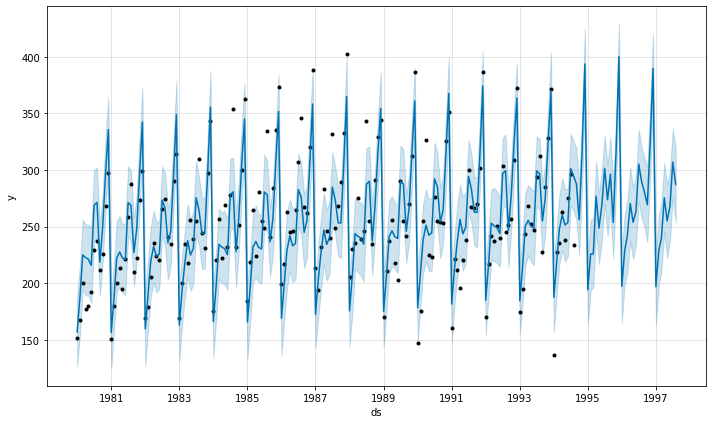

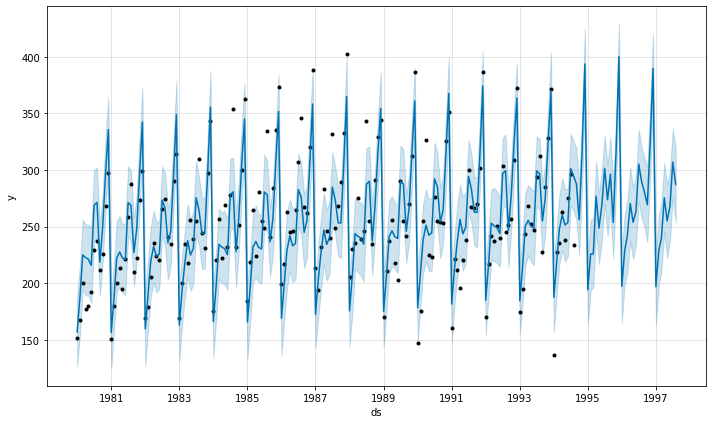

In [23]:

future = fbp_model.make_future_dataframe(periods=36, freq = 'm')
forecast = fbp_model.predict(future)
fbp_model.plot(forecast)

In [24]:
int(forecast[(forecast.ds >= '1995-01-01') & (forecast.ds < '1996-01-01')]['yhat'].sum())

3285

# together

In [49]:
forecast['ds'] = forecast['ds'] + pd.DateOffset(days=1)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1980-01-02,240.394290,126.287936,189.494933,240.394290,240.394290,-83.655710,-83.655710,-83.655710,-83.655710,-83.655710,-83.655710,0.0,0.0,0.0,156.738579
1,1980-02-02,240.593235,155.073442,217.177072,240.593235,240.593235,-51.845052,-51.845052,-51.845052,-51.845052,-51.845052,-51.845052,0.0,0.0,0.0,188.748183
2,1980-03-02,240.779345,194.480970,256.357040,240.779345,240.779345,-15.825882,-15.825882,-15.825882,-15.825882,-15.825882,-15.825882,0.0,0.0,0.0,224.953463
3,1980-04-02,240.978290,189.046115,251.679725,240.978290,240.978290,-18.397207,-18.397207,-18.397207,-18.397207,-18.397207,-18.397207,0.0,0.0,0.0,222.581083
4,1980-05-02,241.170817,189.062677,251.675895,241.170817,241.170817,-20.066009,-20.066009,-20.066009,-20.066009,-20.066009,-20.066009,0.0,0.0,0.0,221.104809
5,1980-06-02,241.369763,182.616175,248.492337,241.369763,241.369763,-25.575818,-25.575818,-25.575818,-25.575818,-25.575818,-25.575818,0.0,0.0,0.0,215.793945
6,1980-07-02,241.562290,237.796498,300.338206,241.562290,241.562290,27.241372,27.241372,27.241372,27.241372,27.241372,27.241372,0.0,0.0,0.0,268.803663
7,1980-08-02,241.761235,239.930093,302.362495,241.761235,241.761235,29.577895,29.577895,29.577895,29.577895,29.577895,29.577895,0.0,0.0,0.0,271.339130
8,1980-09-02,241.960181,188.742293,249.530661,241.960181,241.960181,-23.320525,-23.320525,-23.320525,-23.320525,-23.320525,-23.320525,0.0,0.0,0.0,218.639656
9,1980-10-02,242.152708,218.086437,279.687163,242.152708,242.152708,7.357724,7.357724,7.357724,7.357724,7.357724,7.357724,0.0,0.0,0.0,249.510432


In [55]:
wine_join_df = wine2.reset_index()[:]
wine_join_df.columns = ['date' , 'sales' , 'sarima']
#wine_join_df['date'] = wine_join_df['date'].astype(str)

fbp_join_df = forecast[['ds','yhat']][:]
fbp_join_df.columns = ['date' , 'fbp']
#fbp_join_df['date'] = fbp_join_df['date'].astype(str)


together_df = pd.merge(wine_join_df
                     ,fbp_join_df
                       ,how='left'
                    ,left_on = 'date'
                    ,right_on = 'date')


together_df['sarima'].sum()


9415.281928510112

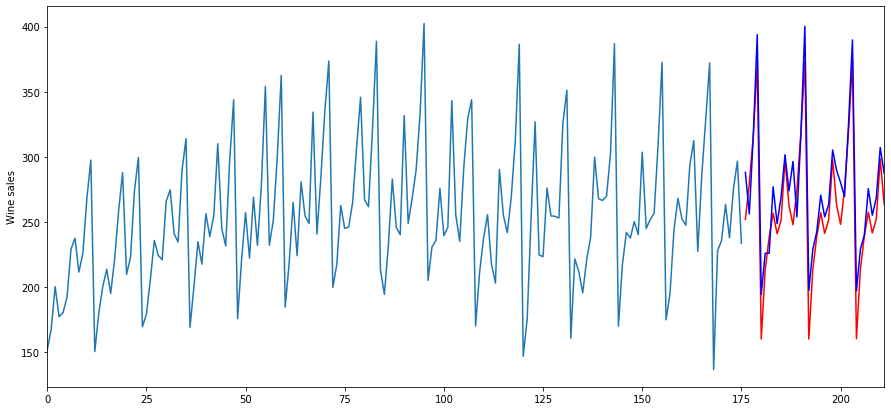

In [57]:
plt.figure(figsize(15,7))
together_df.sales.plot()
together_df.sarima.plot(color='r')
together_df.fbp.plot(color='b')
plt.ylabel('Wine sales')
pylab.show()

# other example

In [ ]:
df_input = pd.read_excel('./data/for_python.xlsx')

In [ ]:
df_input.groupby()